In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
#EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "gaussian_filtered_images",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3662 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[4 0 1 0 2 1 2 2 2 3 2 3 2 2 2 1 2 4 2 3 1 0 2 3 3 2 4 2 0 3 3 2]


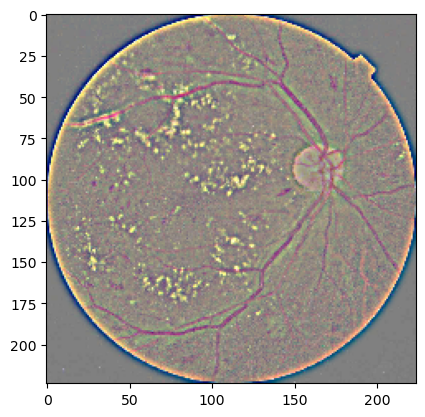

In [6]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[10].numpy().astype("uint8"))

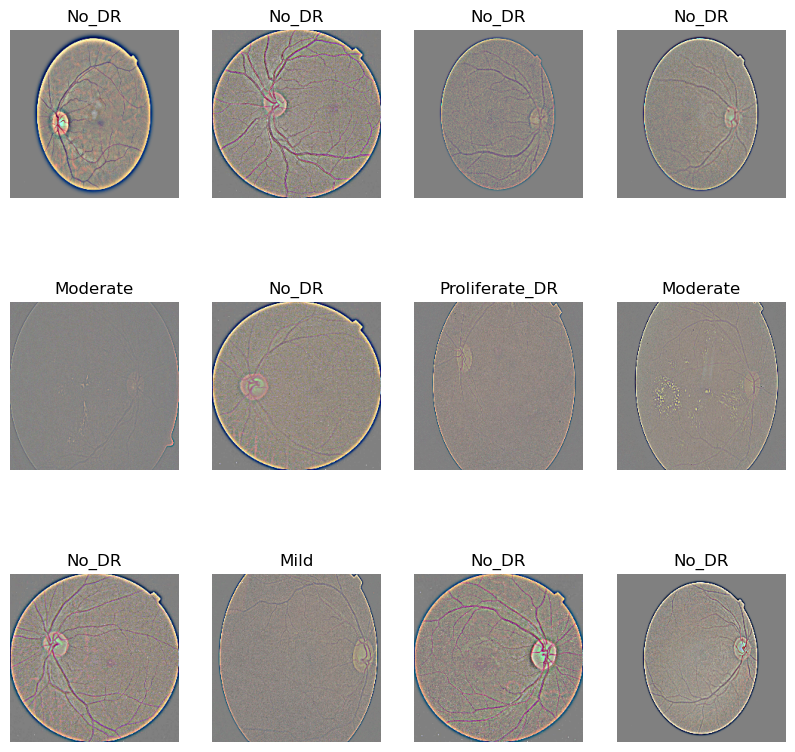

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

115

In [9]:
115*32

3680

80%=>train
20%=>  10% validation  +  10% test

In [10]:
train_size = 0.8
len(dataset)*train_size

92.0

In [11]:
train_ds = dataset.take(92)
len(train_ds)

92

In [12]:
test_ds = dataset.skip(92)
len(test_ds)

23

In [13]:
val_size=0.1
len(dataset)*val_size

11.5

In [14]:
val_ds = test_ds.take(11)
len(val_ds)

11

In [15]:
test_ds = test_ds.skip(11)
len(test_ds)

12

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

92

In [19]:
len(val_ds)

11

In [20]:
len(test_ds)

12

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./223),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
92/92 [==============================] - 231s 2s/step - loss: 1.1708 - accuracy: 0.5140 - val_loss: 1.0768 - val_accuracy: 0.6023
Epoch 2/25
92/92 [==============================] - 191s 2s/step - loss: 1.0184 - accuracy: 0.6319 - val_loss: 0.9769 - val_accuracy: 0.6676
Epoch 3/25
92/92 [==============================] - 189s 2s/step - loss: 0.9720 - accuracy: 0.6541 - val_loss: 0.8687 - val_accuracy: 0.6676
Epoch 4/25
92/92 [==============================] - 189s 2s/step - loss: 0.8867 - accuracy: 0.6883 - val_loss: 0.8641 - val_accuracy: 0.6761
Epoch 5/25
92/92 [==============================] - 188s 2s/step - loss: 0.8691 - accuracy: 0.6883 - val_loss: 0.8171 - val_accuracy: 0.6847
Epoch 6/25
92/92 [==============================] - 241s 3s/step - loss: 0.8271 - accuracy: 0.7061 - val_loss: 0.8507 - val_accuracy: 0.6903
Epoch 7/25
92/92 [==============================] - 218s 2s/step - loss: 0.8313 - accuracy: 0.7064 - val_loss: 0.8530 - val_accuracy: 0.6790
Epoch 8/25
92

In [29]:
scores = model.evaluate(test_ds)

12/12 [==============================] - 18s 475ms/step - loss: 0.6815 - accuracy: 0.7552


In [30]:
scores

[0.6815341114997864, 0.7552083134651184]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 92}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

25

In [36]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.1707720756530762,
 1.0183740854263306,
 0.9720099568367004,
 0.8867291212081909,
 0.8691399693489075]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

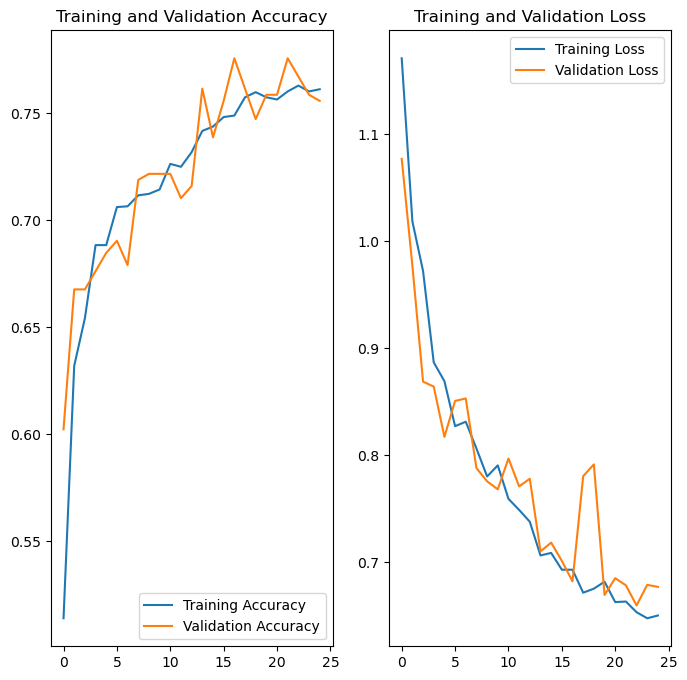

In [39]:
EPOCHS=25
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Moderate
1/1 [==============================] - 2s 2s/step
predicted label: Moderate


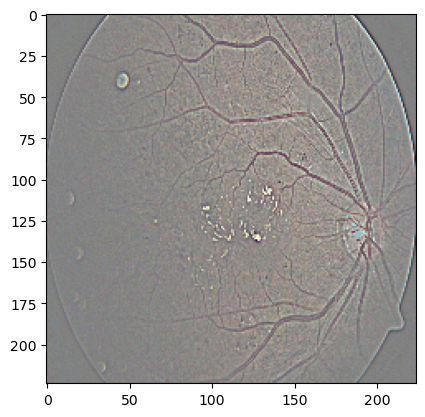

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 63ms/step


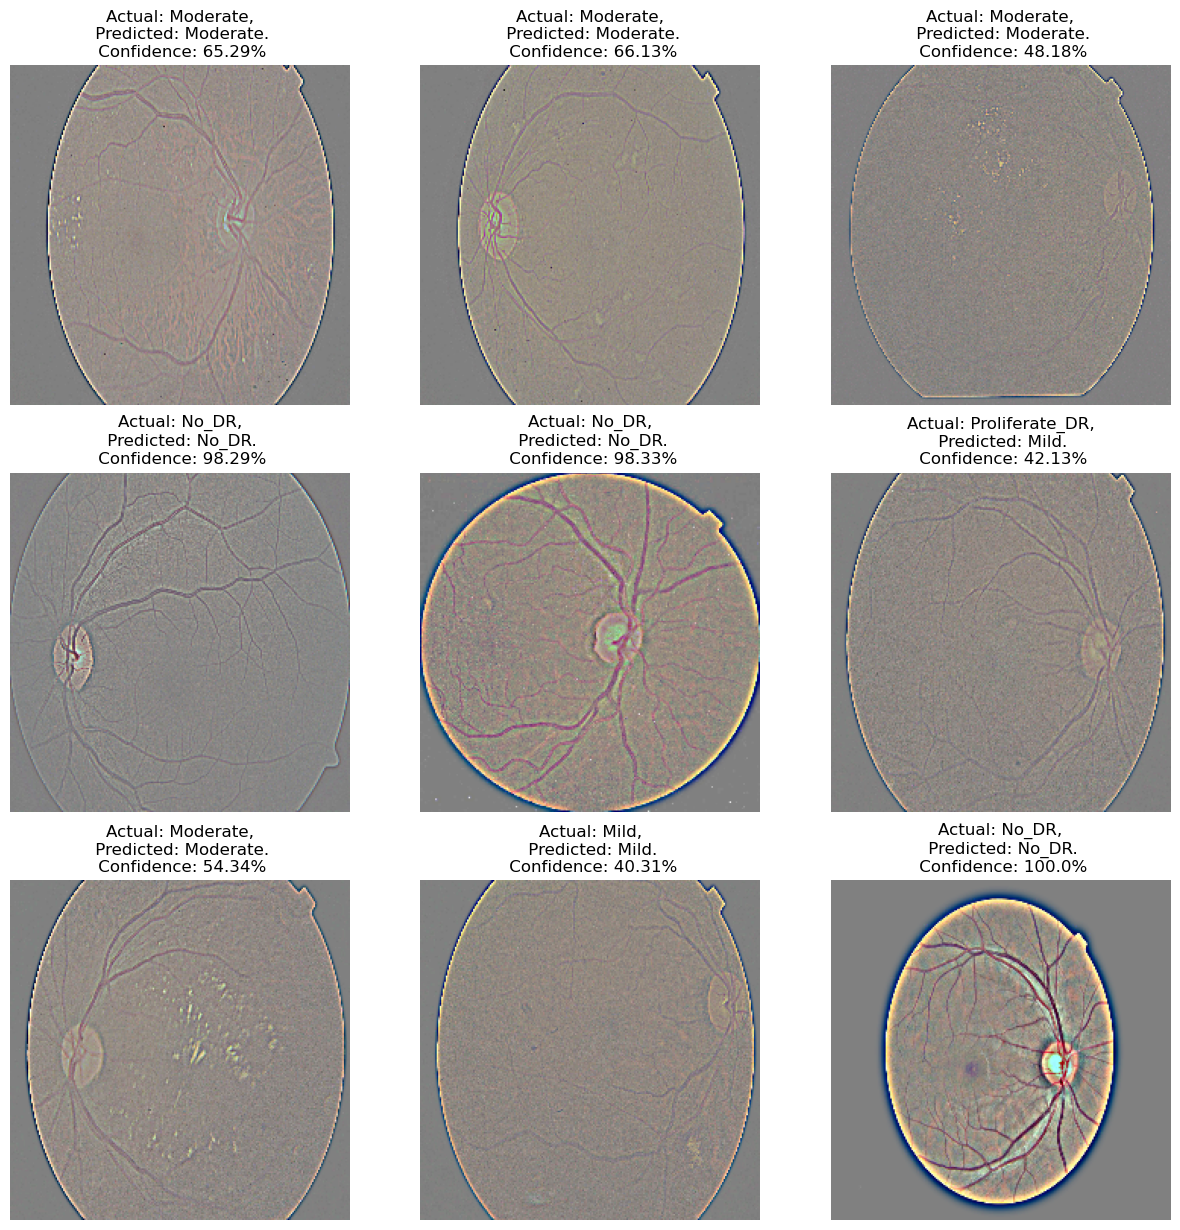

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [46]:
import os
model_version=max([int(i) for i in os.listdir("model") + [0]])+1
model.save(f"model/{model_version}")

INFO:tensorflow:Assets written to: model/1\assets


INFO:tensorflow:Assets written to: model/1\assets


In [47]:
model.save("../nneeww.h5")

C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
model.save("nneewwhfive.h5")